# <font color = 'indianred'> **Setting up the Environment** </font>



In [1]:
 # CHANGE FOLDERS AS PER YOUR SETUP
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate -U -qq
    base_folder = Path("/content/drive/MyDrive/BUAN 6342 NLP")

from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorWithPadding, pipeline
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
import evaluate

import torch
from torch.utils.data import DataLoader

import wandb

import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

import textwrap

import evaluate
import numpy as np
from scipy.special import softmax
from scipy.special import logsumexp

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.9 MB/s eta 0:00:00


In [2]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
data_folder = base_folder/'3. Class Files/0_Data_Folder'
model_folder = base_folder/'4. Assignments/Assignment 7/models'
model_folder.mkdir(exist_ok=True)

# <font color = 'indianred'> **Exploring and Understanding Dataset**

## <font color = 'indianred'> **Stack Exchange MultiClass Dataset**</font>

- In this HW, you will identify tags for stack exchange Questions.
- This data is a subset of data available in a Kaggle Competition.
- The given dataset has different questions asked in the StackExchange website for various technical domains.
- We have fetched only those questions that contain the top 10 individual tags.
- **Each question has only one tag. This means that this is a <font color = "indianred">multi-class classification problem.**</font>
- These are the ten categories for tags in the data.

<div style="margin-left:5%">


| Index| Tag  |
|:-------:|:-------------:|
| 0     | C#          |
| 1     | java        |
| 2     | php         |
| 3     | javascript  |
| 4     | android     |
| 5     | jquery      |
| 6     | c++         |
| 7     | python      |
| 8     | iphone      |
| 9     | asp.net     |

</div>

## <font color = 'indianred'> **Load Data set**
    


In [3]:
stack_dataset = load_dataset('csv', data_files= str(data_folder /'multiclass_hw_basic_clean (1).csv'))

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

## <font color = 'indianred'> **Understanding your data**

In [4]:
print(stack_dataset)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0.1', 'Unnamed: 0', 'Title', 'Body', 'cleaned_text', 'Tags', 'Tag_Number_final', 'combined_text', 'basic_cleaned_text'],
        num_rows: 188878
    })
})


## <font color = 'indianred'> **Understanding the datatype of columns**


In [5]:
stack_dataset['train'].features

{'Unnamed: 0.1': Value(dtype='int64', id=None),
 'Unnamed: 0': Value(dtype='int64', id=None),
 'Title': Value(dtype='string', id=None),
 'Body': Value(dtype='string', id=None),
 'cleaned_text': Value(dtype='string', id=None),
 'Tags': Value(dtype='string', id=None),
 'Tag_Number_final': Value(dtype='int64', id=None),
 'combined_text': Value(dtype='string', id=None),
 'basic_cleaned_text': Value(dtype='string', id=None)}

 - As you can see the dataset has lot of faeatures. However they are not all useful.
 - Title is the title of the stack exchange post
 - Body is the main text of the post
 - combined_text is Title and Body combined with no pre-processing
 - basic_cleaned_text is Title and Body combined with basic preprocessing (remove html tags, urls, emails).
 - cleaned_text - Here we have combined Body and Text and has done some motre pre-propcessing in addition to basic (removing stopwords, lammetization)
 - Tags - names of programming language to which the post belongs
 - Tag_Number_final - index corresponding to Tags

 - **Your goal in this HW is to predict Tags given Body and Title of the post**
 - **You will use Tag_Number_final and basic_cleaned_text for this HW**


In [6]:
# Assuming 'stack_dataset' is a huggingface dataset
# Select only the desired columns and rename them
selected_columns = {
    'text': stack_dataset['train']['basic_cleaned_text'],
    'label': stack_dataset['train']['Tag_Number_final']
}

# Create a new dataset with the selected columns
stack_selected_columns = Dataset.from_dict(selected_columns)

In [7]:
stack_selected_columns

Dataset({
    features: ['text', 'label'],
    num_rows: 188878
})

In [8]:
stack_selected_columns.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [9]:
stack_selected_columns['label'][:10]

[8, 4, 3, 9, 4, 0, 3, 2, 0, 7]

In [10]:
class_names = ['c#', 'java', 'php','javascript', 'android', 'jquery', 'c++',  'python', 'iphone', 'asp.net']

In [11]:
# Cast the 'label' column of stack_selected_columns to the ClassLabel type with specified class names from class_names.
stack_selected_columns = stack_selected_columns.cast_column('label', ClassLabel(names = class_names))

Casting the dataset:   0%|          | 0/188878 [00:00<?, ? examples/s]

In [12]:
stack_selected_columns.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net'], id=None)}

## <font color = 'pickle'> **Filtering Larger Reviews**</font>

In [13]:
# Filter samples with more than 400 words
def filter_long_samples(example):
    # Check if 'text' is not None
    if example['text'] is not None:
        return len(example['text'].split()) > 400
    else:
        return False  # Return False if 'text' is None

In [14]:
stack_dataset_long = stack_selected_columns.filter(filter_long_samples)

Filter:   0%|          | 0/188878 [00:00<?, ? examples/s]

In [15]:
stack_dataset_long

Dataset({
    features: ['text', 'label'],
    num_rows: 4772
})

In [16]:
stack_dataset_long.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net'], id=None)}

## Splitting the data

In [17]:
# Shuffle the dataset
stack_dataset_long = stack_dataset_long.shuffle(seed=42)

# Split the dataset into train and test sets (80% train, 20% test)
train_test_split = stack_dataset_long.train_test_split(test_size=0.2)

# Extract the train and test datasets
train_split = train_test_split['train']
test_split = train_test_split['test']

# Split the train dataset into train and validation sets (80% train, 20% validation of the original train set)
train_val_split = train_split.train_test_split(test_size=0.2)

# Extract the train and validation datasets
train_split = train_val_split['train']
valid_split = train_val_split['test']

In [18]:
train_split

Dataset({
    features: ['text', 'label'],
    num_rows: 3053
})

In [19]:
test_split

Dataset({
    features: ['text', 'label'],
    num_rows: 955
})

In [20]:
valid_split

Dataset({
    features: ['text', 'label'],
    num_rows: 764
})

## <font color = 'pickle'> **Create subset for experimentation** </font>

In [21]:
train_split_small = train_split.shuffle(seed=42).select(range(10))
val_split_small = valid_split.shuffle(seed=42).select(range(10))
test_split_small = test_split.shuffle(seed=42).select(range(10))

## <font color = 'pickle'> **Combine splits**</font>

In [22]:
train_val = DatasetDict(
    {"train": train_split, "valid": valid_split})
train_val_small = DatasetDict(
    {"train": train_split_small, "valid": val_split_small})

In [23]:
train_val

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3053
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 764
    })
})

In [24]:
train_val_small

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 10
    })
})

In [25]:
train_val.set_format(type='pandas')

In [26]:
df_train = train_val['train'][:]

<Axes: >

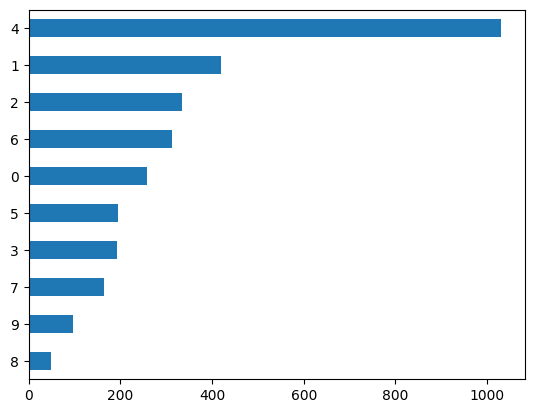

In [27]:
# check ditsribution of class labels in training dataset
df_train['label'].value_counts(ascending=True).plot.barh()

In [28]:
# check distribution of text length
df_train['words_per_review'] = df_train['text'].str.split().apply(len)

<Axes: >

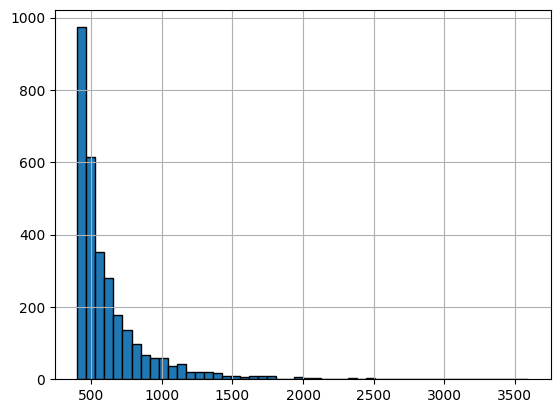

In [29]:
# Plot a histogram of the 'words_per_review' column
df_train['words_per_review'].hist(bins=50, edgecolor='black')

In [30]:
train_val.reset_format()

## <font color = 'pickle'> **Tokenization**</font>

###  <font color = 'pickle'> **Load pre-trained Tokenizer** </font>

In [31]:
from transformers import AutoTokenizer
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

##  <font color = 'pickle'> **Create Custom_Collate function**

In [32]:
def collate_function(batch, tokenizer, max_length, stride):

    text_batch = [item['text'] for item in batch]

    # Check if any of the batch items has 'label', if so process labels.
    if all('label' in item for item in batch):
        label_batch = [item['label'] for item in batch]
        doc_labels = torch.tensor(label_batch, dtype=torch.long)
    else:
        doc_labels = None

    # Tokenize the batch of texts
    tokenized = tokenizer(text_batch,
                          padding='longest',
                          truncation=True,
                          return_tensors='pt',
                          max_length=max_length,
                          return_overflowing_tokens=True,
                          stride=stride)

    # Flatten the chunks if necessary using overflow_to_sample_mapping
    overflow_to_sample_mapping = tokenized.get("overflow_to_sample_mapping", None)

    result = {
        **tokenized,
        "overflow_to_sample_mapping": overflow_to_sample_mapping,
    }

    # Repeat labels for the chunks based on overflow_to_sample_mapping, only if labels are present
    if doc_labels is not None and overflow_to_sample_mapping is not None:
        labels = doc_labels[overflow_to_sample_mapping]
        result["labels"] = labels
        result["doc_labels"] = doc_labels

    return result

##  <font color = 'pickle'> **Model Config File**

###  <font color = 'pickle'> **Download config file of pre-trained Model**</font>

In [33]:
from transformers import AutoConfig

In [34]:
config = AutoConfig.from_pretrained(checkpoint)

In [35]:
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

###  <font color = 'pickle'> **Modify Configuration File**</font>
- We need to modify configuration fie to add ids to  label and label to ids mapping
- Adding id2label and label2id to the configuration file provides a consistent, interpretable, and user-friendly way to handle model outputs.

In [36]:
id2label = {}
for id_, label_ in enumerate(class_names):
    id2label[str(id_)] = label_
id2label

{'0': 'c#',
 '1': 'java',
 '2': 'php',
 '3': 'javascript',
 '4': 'android',
 '5': 'jquery',
 '6': 'c++',
 '7': 'python',
 '8': 'iphone',
 '9': 'asp.net'}

In [37]:
label2id = {}
for id_, label_ in enumerate(class_names):
    label2id[label_] = id_
label2id

{'c#': 0,
 'java': 1,
 'php': 2,
 'javascript': 3,
 'android': 4,
 'jquery': 5,
 'c++': 6,
 'python': 7,
 'iphone': 8,
 'asp.net': 9}

In [38]:
config.id2label = id2label
config.label2id = label2id

In [39]:
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "c#",
    "1": "java",
    "2": "php",
    "3": "javascript",
    "4": "android",
    "5": "jquery",
    "6": "c++",
    "7": "python",
    "8": "iphone",
    "9": "asp.net"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "android": 4,
    "asp.net": 9,
    "c#": 0,
    "c++": 6,
    "iphone": 8,
    "java": 1,
    "javascript": 3,
    "jquery": 5,
    "php": 2,
    "python": 7
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cac

##  <font color = 'pickle'> **Download pre-trained model**

In [40]:
from transformers import AutoModelForSequenceClassification

In [41]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)  # We are using the same checkpiont as we have used for tokenizer

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## <font color = 'pickle'> **Model Input/Collate Function** </font>

In [42]:
from functools import partial

In [43]:
collate_fn = partial(collate_function, tokenizer=tokenizer,max_length = 512, stride = 256)

In [44]:
model_inputs = collate_fn(train_val_small['train'])

In [45]:
model_inputs

{'input_ids': tensor([[  101,  8084,  2007,  ..., 23352,  2620,   102],
         [  101,  1011,  1011,  ...,  1027,  1016,   102],
         [  101, 23352,  2620,  ...,  1997,  4526,   102],
         ...,
         [  101,  1007,  6185,  ...,  1012,  4722,   102],
         [  101,  1013, 11924,  ...,  1012, 10439,   102],
         [  101,  1012,  4722,  ...,     0,     0,     0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'overflow_to_sample_mapping': tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 2, 2, 

## <font color = 'pickle'> **Final Functions**</font>

In [47]:
# import functional from torch as F
import torch.nn.functional as F

def collate_function(batch, tokenizer, max_length, stride):


    text_batch = [item['text'] for item in batch]

    # Check if any of the batch items has 'label', if so process labels.
    if all('label' in item for item in batch):
        label_batch = [item['label'] for item in batch]
        doc_labels = torch.tensor(label_batch, dtype=torch.long)
    else:
        doc_labels = None


    # Tokenize the batch of texts
    tokenized = tokenizer(text_batch,
                          padding='longest',
                          truncation=True,
                          return_tensors='pt',
                          max_length=max_length,
                          return_overflowing_tokens=True,
                          stride=stride)

    # Flatten the chunks if necessary using overflow_to_sample_mapping
    overflow_to_sample_mapping = tokenized.get("overflow_to_sample_mapping", None)

    result = {
        **tokenized,
        "overflow_to_sample_mapping": overflow_to_sample_mapping,
    }

    # Repeat labels for the chunks based on overflow_to_sample_mapping, only if labels are present
    if doc_labels is not None and overflow_to_sample_mapping is not None:
        labels = doc_labels[overflow_to_sample_mapping]
        result["labels"] = labels
        result["doc_labels"] = doc_labels

    return result

In [48]:
import numpy as np
from scipy.special import softmax
from scipy.special import logsumexp

def stable_log_softmax(x):
    # Subtract the max for numerical stability along the last axis (axis=-1)
    x_max = np.max(x, axis=-1, keepdims=True)
    # Use logsumexp for better numerical stability
    log_softmax = x - x_max - logsumexp(x - x_max, axis=-1, keepdims=True)
    return log_softmax

In [49]:
def aggregate_predictions (logits, aggregation_method, overflow_to_sample_mapping):

    probabilities = softmax(logits, axis=-1)
    log_probabilities = stable_log_softmax(logits)

    # print('log_probs', log_probabilities.shape)
    # print('overflow_to_sample_mapping', overflow_to_sample_mapping.shape)

    # Get unique documents

    unique_docs, inverse_indices = np.unique(overflow_to_sample_mapping, return_inverse=True)
    num_docs = unique_docs.size

    # Create a mask for documents
    mask = overflow_to_sample_mapping[:, None] == unique_docs[None, :]

    # Initialize the aggregated_predictions variable
    aggregated_predictions = None

    if aggregation_method == "average_log_probs":
        # Compute average probabilities using NumPy
        avg_log_probs = (log_probabilities[:, None, :] * mask[:, :, None].astype(float)).sum(axis=0) / mask.sum(axis=0, keepdims=True).transpose((1, 0))
        aggregated_predictions = np.argmax(avg_log_probs, axis=-1)
        scores = np.exp(avg_log_probs.max(axis=-1))

    elif aggregation_method == "average_probs":
        # Compute average probabilities using NumPy
        avg_probs = (probabilities[:, None, :] * mask[:, :, None].astype(float)).sum(axis=0) / mask.sum(axis=0, keepdims=True).transpose((1, 0))
        aggregated_predictions = np.argmax(avg_probs, axis=-1)
        scores  = avg_probs.max(axis=-1)

    elif aggregation_method == "max_probs":
        # Compute max probabilities per document
        max_values = np.where(mask[:, :, None], log_probabilities[:, None, :], float('-inf'))
        max_log_probs = np.max(max_values, axis=0)
        aggregated_predictions = np.argmax(max_log_probs, axis=-1)
        scores = np.exp(max_log_probs.max(axis=-1))

    elif aggregation_method == "majority_vote":
        # Convert logits to actual predictions before voting
        predictions = np.argmax(logits, axis=1)
        # Tally the votes for each document
        vote_tally = np.zeros((num_docs, logits.shape[-1]), dtype=int)
        np.add.at(vote_tally, overflow_to_sample_mapping, np.eye(logits.shape[-1], dtype=int)[predictions])
        # Determine the majority vote for each document
        aggregated_predictions = np.argmax(vote_tally, axis=1)
        scores = vote_tally.max(axis=-1) / vote_tally.sum(axis=-1)
    else:
        raise ValueError(f"Unsupported aggregation_method: {aggregation_method}")

    # # Calculate evaluation metrics using document-level labels
    # metrics = evaluate.combine([
    #     evaluate.load("accuracy"),
    #     evaluate.load("f1", average="macro")
    # ])
    # evaluations = metrics.compute(predictions=aggregated_predictions, references=doc_labels)

    # return evaluations

    return aggregated_predictions, scores

In [50]:
from transformers import Trainer
import torch
import torch.nn as nn
from transformers.trainer_utils import EvalPrediction

class CustomTrainer(Trainer):
    def __init__(self, *args, loss_type="average_log_probs", **kwargs):
        super(CustomTrainer, self).__init__(*args, **kwargs)
        self.loss_type = loss_type
        self.nll_loss = nn.NLLLoss()


    def compute_loss(self, model, inputs, return_outputs=False):

        labels = inputs["labels"]
        overflow_to_sample_mapping = inputs.pop("overflow_to_sample_mapping", None)
        doc_labels = inputs.pop("doc_labels", None)
        logits = model(**inputs).logits

        # print(logits)

        # convert logits to log probabilities, probabilities
        log_probabilities = F.log_softmax(logits, dim=-1)
        probabilities = F.softmax(logits, dim=-1)



        # Number of unique documents and chunks
        num_docs = doc_labels.size(0)
        num_chunks = overflow_to_sample_mapping.size(0)

        # Ensure overflow_to_sample_mapping is on the same device as doc_labels
        overflow_to_sample_mapping = overflow_to_sample_mapping.to(doc_labels.device)

        # Create a tensor representing each unique doc
        unique_docs = torch.arange(num_docs).to(doc_labels.device)

        # Create the mask
        mask = overflow_to_sample_mapping[:, None] == unique_docs[None, :]


        if self.loss_type == "average_log_probs":
            avg_log_probs = (log_probabilities[:, None, :] * mask.unsqueeze(-1).float()).sum(0) / mask.sum(0, keepdim=True).T

            # print('avg_log_probs_shape', avg_log_probs.shape)
            loss = self.nll_loss(avg_log_probs, doc_labels)
            # print(loss)

        elif self.loss_type == "average_probs":
            avg_probs = (probabilities[:, None, :] * mask.unsqueeze(-1).float()).sum(0) / mask.sum(0, keepdim=True).T

            avg_log_probs = torch.log(avg_probs)
            # print('avg_log_probs_shape', avg_log_probs.shape)
            loss = self.nll_loss(avg_log_probs, doc_labels)
            # print(loss)

        elif self.loss_type == "max":
            max_values = torch.where(mask.unsqueeze(-1), log_probabilities[:, None, :], torch.tensor(float('-inf'), device=log_probabilities.device))
            max_log_probs = max_values.max(dim=0).values
            # print('max_log_probs_shape', max_log_probs.shape)
            loss = self.nll_loss(max_log_probs, doc_labels)
            # print(loss)

        elif self.loss_type == "loss_per_chunk":
            # print('log_probs_shape', log_probabilities.shape)
            loss = self.nll_loss(log_probabilities, labels.view(-1))
            # print(loss)

        else:
            raise ValueError(f"Unsupported loss_type: {self.loss_type}")


        return (loss, logits) if return_outputs else loss

In [51]:
import wandb
# setup wandb
wandb.login()  # you will need to craete wandb account first
# Set project name for logging
%env WANDB_PROJECT = nlp_course_fall_2023-classification-stack-exchange

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=nlp_course_fall_2023-sentiment-analysis-stack-exchange


## <font color = 'pickle'> **Hyperparameters and Checkpointing**</font>

In [53]:
from transformers import TrainingArguments

# Configure training parameters for Experiment 1
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=1,  # Total number of training epochs
    per_device_train_batch_size=8,  # Number of samples per training batch for each device
    per_device_eval_batch_size=8,  # Number of samples per evaluation batch for each device
    gradient_accumulation_steps=2,  # Accumulate gradients to effectively increase batch size
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer
    fp16=True,  # Use mixed precision training for memory optimization
    remove_unused_columns=False,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=1,  # Perform evaluation every 1 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=1,  # Save a model checkpoint every 1 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints

    # Logging configurations
    logging_strategy='steps',
    logging_steps=1,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name='HW7_Part_A',  # Experiment name for Weights & Biases

    gradient_checkpointing=True,
)

##  <font color = 'pickle'> **Initialize Trainer**</font>

In [54]:
checkpoint = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config = config)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
collate_fn = partial(collate_function, tokenizer=tokenizer,max_length = 512, stride = 256)
trainer = CustomTrainer(
    # loss_type = "average_log_probs",
    # loss_type = "average_probs",
    # loss_type = "max",
    loss_type = "loss_per_chunk",
    model=model,
    args=training_args,
    train_dataset=train_val_small["train"],
    eval_dataset=train_val_small["valid"],
    data_collator=collate_fn,
    tokenizer=tokenizer,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##  <font color = 'pickle'> **Start Training**

In [55]:
train_val_small["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 10
})

In [56]:
trainer.train() # start training

wandb: Currently logged in as: mitradevangshu (devangshu). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
1,2.185400,2.202743


TrainOutput(global_step=1, training_loss=2.185394763946533, metrics={'train_runtime': 21.4145, 'train_samples_per_second': 0.467, 'train_steps_per_second': 0.047, 'total_flos': 28944294973440.0, 'train_loss': 2.185394763946533, 'epoch': 1.0})

In [57]:
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 1.


## <font color = 'pickle'> **Evaluation**

### <font color = 'pickle'> **Check performance on validation set**</font>

In [58]:
train_val_small['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 10
})

In [59]:
num_obs = 0
chunks = 0
batches = 0
for x in trainer.get_test_dataloader(train_val_small['train']  ):
    print(x['input_ids'].shape)
    print(x['labels'].shape)
    print(x['doc_labels'].shape)
    print(x.keys())
    num_obs += x['doc_labels'].shape[0]
    chunks += x['input_ids'].shape[0]
    print(x['overflow_to_sample_mapping'])
    batches += 1

torch.Size([89, 512])
torch.Size([89])
torch.Size([8])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'overflow_to_sample_mapping', 'labels', 'doc_labels'])
tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], device='cuda:0')
torch.Size([21, 512])
torch.Size([21])
torch.Size([2])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'overflow_to_sample_mapping', 'labels', 'doc_labels'])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')


In [64]:
from evaluate import load
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification
from evaluate import load
import torch

# Correct path construction to the checkpoint directory
checkpoint_dir = model_folder / "checkpoint-1"

# Load the model from the checkpoint directory
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_dir)

# Make sure to use 'cuda' if a GPU is available.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
accuracy_metric = load("accuracy")
model = model.to(device=device)

# Loop over batches
for batch in trainer.get_test_dataloader(train_val_small['train']):
    model.eval()

    # Extract and remove the `doc_labels` and `overflow_to_sample_mapping` from the batch
    # before sending the batch to the model
    doc_labels = batch.pop("doc_labels", None).cpu().numpy()
    overflow_to_sample_mapping = batch.pop("overflow_to_sample_mapping", None).cpu().numpy()

    # Move the remaining batch to the same device as the model
    batch = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():  # Disable gradient calculation
        outputs = model(**batch)
        logits = outputs.logits.cpu().numpy()  # Move logits back to CPU for numpy operations

        aggregated_predictions, scores  = aggregate_predictions(logits=logits,
                                                        aggregation_method="average_log_probs",
                                                        overflow_to_sample_mapping=overflow_to_sample_mapping)

        accuracy_metric.add_batch(predictions=aggregated_predictions, references=doc_labels)

final_accuracy = accuracy_metric.compute()
print("Final Accuracy: ", final_accuracy)

Final Accuracy:  {'accuracy': 0.6}


In [65]:
from torch.utils.data import DataLoader
from transformers import PreTrainedModel
from evaluate import load

def evaluate_model(dataloader: DataLoader, model: PreTrainedModel, metric_only: bool = True, aggregation_method: str ='average_log_probs'):
    # Load the accuracy metric
    accuracy_metric = load("accuracy")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device=device)

    predictions = []
    all_doc_labels = []

    # Loop over batches
    for batch in dataloader:
        model.eval()
        doc_labels = batch.pop("doc_labels", None).cpu().numpy()
        overflow_to_sample_mapping = batch.pop("overflow_to_sample_mapping", None).cpu().numpy()
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits.cpu().numpy()
            aggregated_predictions, scores = aggregate_predictions(logits=logits,
                                                            aggregation_method=aggregation_method,
                                                            overflow_to_sample_mapping=overflow_to_sample_mapping)

            accuracy_metric.add_batch(predictions=aggregated_predictions, references=doc_labels)
            if not metric_only:
                predictions.extend(aggregated_predictions)
                all_doc_labels.extend(doc_labels)

    # Calculate and return the final accuracy.
    final_accuracy = accuracy_metric.compute()['accuracy']

    if metric_only:
        return final_accuracy
    else:
        return final_accuracy, predictions, all_doc_labels

In [66]:
train_accuracy = evaluate_model(trainer.get_test_dataloader(train_val_small['train']), model, metric_only=True)
train_accuracy

0.6

In [67]:
val_accuracy, val_predictions, val_labels = evaluate_model(trainer.get_test_dataloader(train_val_small['train']), model, metric_only=False)
val_accuracy

0.6

In [68]:
val_predictions

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

In [69]:
val_labels

[2, 4, 4, 7, 2, 4, 4, 4, 1, 4]

In [70]:
# aggregation_method = "average_log_probs"
# aggregation_method = "average_probs"
# aggregation_method = "max_probs"
aggregation_method = "majority_vote"

# val_accuracy, val_predictions, val_labels = evaluate_model(trainer.get_test_dataloader(train_val_small['train']),
#                                                            model, metric_only=False,aggregation_method=aggregation_method)
# print(val_accuracy, val_predictions, val_labels)

val_accuracy = evaluate_model(trainer.get_test_dataloader(train_val_small['train']),
                                                           model, metric_only=True,aggregation_method=aggregation_method)
print(val_accuracy)

0.6


In [71]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

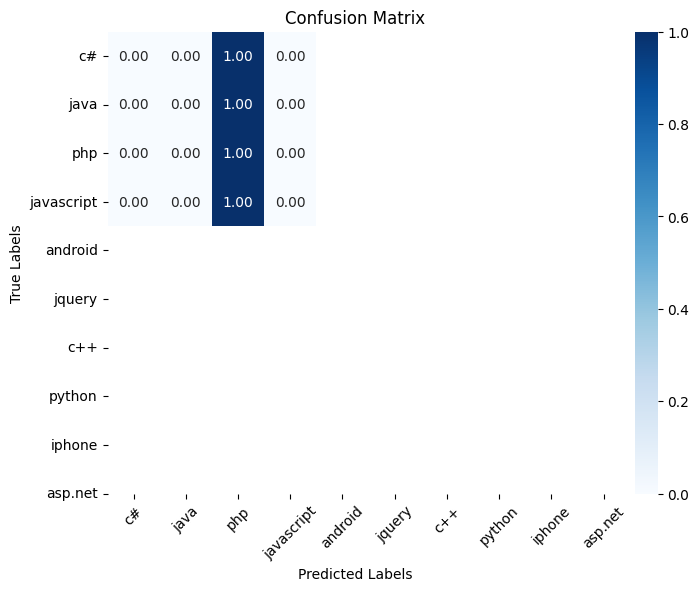

In [72]:
#  Generate the confusion matrix
cm = confusion_matrix(val_labels, val_predictions,normalize='true')

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
ax= sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# Ensure x-labels are vertical
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Ensure y-labels are horizontal
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [74]:
# log the Confusion Matrix to Wandb
wandb.log({"conf_mat": wandb.plot.confusion_matrix(
    preds=val_predictions, y_true=val_labels,
    class_names = ['c#', 'java', 'php','javascript', 'android', 'jquery', 'c++',  'python', 'iphone', 'asp.net'])})

In [75]:
wandb.finish()

eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁▁
train/learning_rate,▁
train/loss,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


#  <font color = 'pickle'> **Inference**

## <font color = 'pickle'> **Test Set Evaluation**

In [78]:
from torch.utils.data import DataLoader
# Correct path construction to the checkpoint directory
checkpoint = model_folder / "checkpoint-1"

# Load the model from the checkpoint directory
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [79]:
model.config

BertConfig {
  "_name_or_path": "/content/drive/MyDrive/BUAN 6342 NLP/4. Assignments/Assignment 7/models/checkpoint-1",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "c#",
    "1": "java",
    "2": "php",
    "3": "javascript",
    "4": "android",
    "5": "jquery",
    "6": "c++",
    "7": "python",
    "8": "iphone",
    "9": "asp.net"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "android": 4,
    "asp.net": 9,
    "c#": 0,
    "c++": 6,
    "iphone": 8,
    "java": 1,
    "javascript": 3,
    "jquery": 5,
    "php": 2,
    "python": 7
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "

In [80]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
collate_fn = partial(collate_function, tokenizer = tokenizer, max_length =512, stride=100)
test_laoder = DataLoader(test_split_small, batch_size=5, collate_fn=collate_fn)

In [81]:
for x in test_laoder:
    print(x['input_ids'].shape)
    print(x['labels'].shape)
    print(x['doc_labels'].shape)
    print(x.keys())
    print(x['overflow_to_sample_mapping'])

torch.Size([16, 512])
torch.Size([16])
torch.Size([5])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'overflow_to_sample_mapping', 'labels', 'doc_labels'])
tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4])
torch.Size([18, 512])
torch.Size([18])
torch.Size([5])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'overflow_to_sample_mapping', 'labels', 'doc_labels'])
tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4])


In [83]:
test_accuracy = evaluate_model(test_laoder, model)
test_accuracy

0.4